In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import collections
import time
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
np.random.seed(42)

In [10]:
train = pd.read_csv('/content/drive/MyDrive/Hackathon/Notch/notch.csv')

In [11]:
train

,Acc_x [m/s^2],Acc_y [m/s^2],Acc_z [m/s^2],AnyFall,NegOutcome
0,0.014282,-0.172332,-0.482754,0,1
1,0.016369,-0.174700,-0.417005,0,1
2,0.088920,0.157522,-0.213992,0,1
3,0.106267,0.282953,-0.159411,0,1
4,-0.005552,0.206771,-0.042602,0,1
...,...,...,...,...,...
82923,-0.121688,-0.068735,0.051570,0,1
82924,0.310388,-0.065545,-0.408271,0,1
82925,0.477990,-0.079820,-0.510297,0,1
82926,0.455851,-0.079109,-0.502064,0,1


## Preprecessing

- sliding window size of 40
- if data contains all fall samples(25 samples) then, label as 'FALL'
- unless, it's all labelled as 'ADL'

In [ ]:
n = 100
X_train, y_train = list(), list()

for i in tqdm(range(0, len(train)-n)):
    temp = list()
    
    temp.append(train['Acc_x [m/s^2]'][i : i + n])
    temp.append(train['Acc_x [m/s^2]'][i : i + n])
    temp.append(train['Acc_x [m/s^2]'][i : i + n])
    
    cnt = collections.Counter(train['NegOutcome'][i: i + n])
    num_adl = cnt[0]
    num_fall = cnt[1]
    
    if num_fall == 30:
        y_train.append(1)
    else:
        y_train.append(0)
    
    X_train.append(temp)

<ipython-input-104-908304e4b4a9>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0, len(train)-n)):


  0%|          | 0/92681 [00:00<?, ?it/s]

In [58]:
n = 100
X_test_adl, X_test_fall, y_test_adl, y_test_fall = list(), list(), list(), list()
for i in tqdm(range(0, len(train) - n, n//3)):
    temp = list()
    
    temp.append(train['Acc_x [m/s^2]'][i : i + n])
    temp.append(train['Acc_x [m/s^2]'][i : i + n])
    temp.append(train['Acc_x [m/s^2]'][i : i + n])
    
    cnt = collections.Counter(train['NegOutcome'][i: i + n])
    num_adl = cnt[0]
    num_fall = cnt[1]
    
    if num_fall > 70:
        y_test_fall.append(1)
        X_test_fall.append(temp)
    else:
        y_test_adl.append(0)
        X_test_adl.append(temp)

<ipython-input-58-fba13d887ca1>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0, len(train) - n, n//3)):


  0%|          | 0/2510 [00:00<?, ?it/s]

In [59]:
print(len(y_test_fall))
print(len(y_test_adl))

2164
346


In [51]:
y_train = y_test_adl + y_test_fall
X_train = X_test_adl + X_test_fall

In [52]:
print('length of test data', len(X_test))

length of test data 79646


## CNN/DENSE model declaration 


In [ ]:
# from tensorflow.keras.layers import Input, Flatten, Conv1D, Embedding, Bidirectional, Dense

# model = keras.Sequential()

# input_shape=(128,40,3)
# # encoder
# model.add(Input(shape=input_shape[1:]))
# model.add(Flatten())
# model.add(Dense(20, input_shape = (256,), activation = 'relu'))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))

# # binary classifier as decoder
# model.add(Dense(name='classifier', units=1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

In [32]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Reshape

model = keras.Sequential()

# encoder
model.add(Input(shape=(n, 3)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=15, activation='relu'))
model.add(Dense(units=10, activation='relu'))

# binary classifier as decoder
model.add(Dense(units=1, activation='sigmoid', name='classifier'))

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 64)           640       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 64)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 32)            6176      
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 32)           0         
 1D)                                                    

## Preparing datasets

In [62]:
X_train = np.asarray(X_train).reshape(-1, n, 3)
y_train = np.asarray(y_train).reshape(-1, )

X_test_fall = np.asarray(X_test_fall).reshape(-1, n, 3)
y_test_fall = np.asarray(y_test_fall).reshape(-1, )
X_test_adl = np.asarray(X_test_adl).reshape(-1, n, 3)
y_test_adl = np.asarray(y_test_adl).reshape(-1, )

In [63]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

# y_train = enc.fit_transform(y_train)
# y_test = enc.fit_transform(y_test)

In [64]:
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [65]:
batch_size = 128

train_data = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)))
train_loader = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size)

# valid_data = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_valid), tf.convert_to_tensor(y_valid)))
# valid_loader = valid_data.shuffle(buffer_size=len(valid_data)).batch(batch_size)

# test_data = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)))
# test_loader = test_data.shuffle(buffer_size=len(test_data)).batch(batch_size)


## Model training

In [37]:
input_dim = train_loader.element_spec[0].shape[2]
output_dim = 2
n_layers = 2
hidden_dim = 256

lr = 0.0001
n_epochs = 40
iterations_per_epoch = len(train_loader)
best_acc = 0.
patience, trials = 15, 0

criterion = tf.keras.losses.BinaryCrossentropy()
lr_schedule = tf.keras.experimental.CosineDecayRestarts(initial_learning_rate=lr, first_decay_steps=iterations_per_epoch * 2)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
epoch_times = []


In [38]:
model.compile(optimizer, criterion,metrics=['accuracy'])

In [39]:
%time history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.2)

Epoch 1/10
518/518 [==============================] - 27s 47ms/step - loss: 0.3699 - accuracy: 0.9004 - val_loss: 0.1636 - val_accuracy: 0.9694
Epoch 2/10
518/518 [==============================] - 25s 47ms/step - loss: 0.2276 - accuracy: 0.9184 - val_loss: 0.1708 - val_accuracy: 0.9625
Epoch 3/10
518/518 [==============================] - 25s 49ms/step - loss: 0.2162 - accuracy: 0.9212 - val_loss: 0.2009 - val_accuracy: 0.9498
Epoch 4/10
518/518 [==============================] - 25s 48ms/step - loss: 0.1939 - accuracy: 0.9276 - val_loss: 0.2471 - val_accuracy: 0.9325
Epoch 5/10
518/518 [==============================] - 24s 47ms/step - loss: 0.1718 - accuracy: 0.9342 - val_loss: 0.1902 - val_accuracy: 0.9472
Epoch 6/10
518/518 [==============================] - 24s 47ms/step - loss: 0.1554 - accuracy: 0.9392 - val_loss: 0.1810 - val_accuracy: 0.9507
Epoch 7/10
518/518 [==============================] - 25s 48ms/step - loss: 0.1480 - accuracy: 0.9422 - val_loss: 0.1686 - val_accuracy:

In [40]:
test_loss, test_accuracy = model.evaluate(test_loader, batch_size=batch_size)
test_accuracy

623/623 [==============================] - 9s 13ms/step - loss: 0.0855 - accuracy: 0.9706


0.9706199765205383

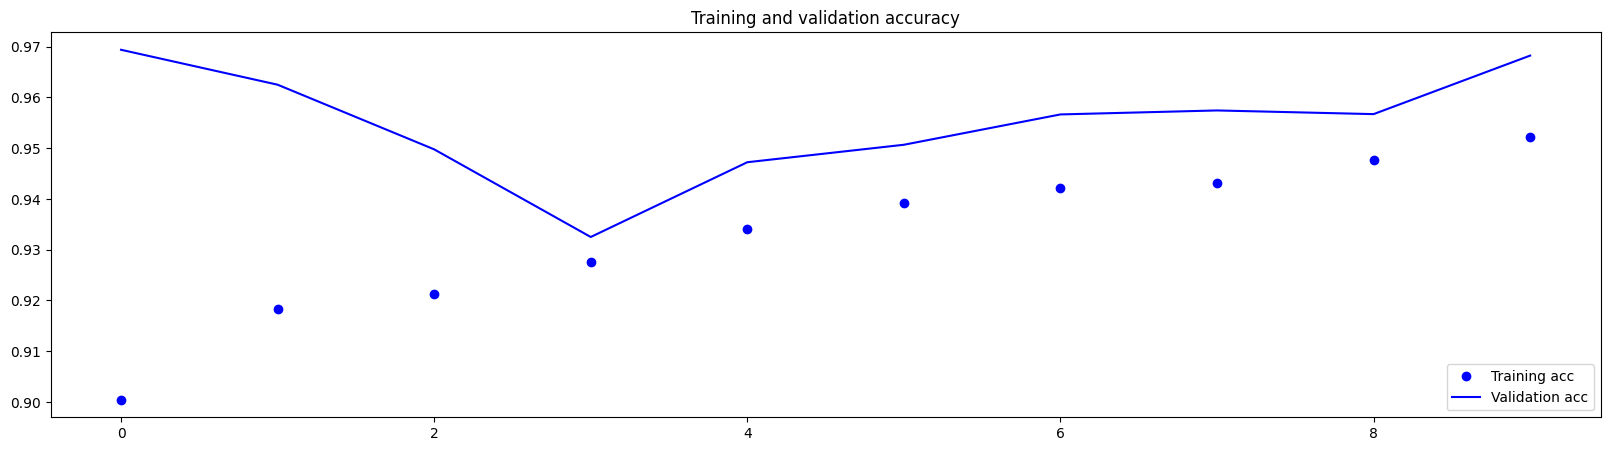

In [43]:
def plot_history(history, samples=10, init_phase_samples=None):
    epochs = history.params['epochs']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]

    fig, ax = plt.subplots(figsize=(20,5))

    ax.plot(acc, 'bo', label='Training acc')
    ax.plot(val_acc, 'b', label='Validation acc')
    ax.set_title('Training and validation accuracy')
    ax.legend()

plot_history(history)

In [66]:
model.save('model.h5')
loaded_model = keras.models.load_model('model.h5')
result = loaded_model(tf.random.uniform((1,n,3))).numpy()
result

array([[0.9996042]], dtype=float32)

In [80]:
result = loaded_model(X_test_fall).numpy()
(result < 0.99).sum()

617

In [82]:
result = loaded_model(X_test_adl).numpy()
(result > 0.99).sum()

42

In [45]:
from tensorflow import lite

converter = lite.TFLiteConverter.from_keras_model(loaded_model)

converter._experimental_default_to_single_batch_in_tensor_list_ops = True

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] 

tfmodel = converter.convert()
open('model.tflite', 'wb').write(tfmodel)

54536

In [ ]:
# run_model = tf.function(lambda x: model(x))
# # This is important, let's fix the input size.
# BATCH_SIZE = 1
# STEPS = 40
# INPUT_SIZE = 3
# concrete_func = run_model.get_concrete_function(
#     tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

# # model directory.
# MODEL_DIR = "keras_lstm"
# model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

# converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
# tflite_model = converter.convert()
# open('model1.tflite', 'wb').write(tfmodel)

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="model1.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

# Set input data
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get output data
output_data = interpreter.get_tensor(output_details[0]['index'])


In [ ]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 34,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]